In [2]:
import numpy as np


def gen_IND_residual(n, residualform="normal"):
    """
    # normal, t, chisq, uniform, default is normal dist.
    # generate the independent data based on different residual form.
    # We need to normalize the variance s.t. variance = 1.
    # So we can only focus on different shapes.
    """
    if (residualform == "normal"):
        eps = np.random.normal(0, 1, n)
        # What is the difference between N(0, sigma^2 I) and N(0, 1)
        # eps <- matrix(rnorm(n * p, 0, 1), n, p)  # spurious correlation
    elif (residualform == "t"):
        # t_{v}, the df = v, then the mean is 0, and the variance is v / (v-2)
        tmp = np.random.standard_t(df=5, size=n)
        eps = tmp / np.sqrt(5/3)
    elif (residualform == "chisq"):  # chisquare
        # chisq_{v}, the df = v, then the mean is v, and the variance is 2*v
        tmp = np.random.chisquare(df=3, size=n)
        eps = (tmp - 3) / np.sqrt(6)
    elif (residualform == "uniform"):
        # Uniform(a, b), mean (a+b)/2, variance (b-a)^2/12
        a, b = -np.sqrt(3), np.sqrt(3)
        s = np.sqrt((b - a) ** 2 / 12)    # Here s = 1
        tmp = np.random.uniform(a, b, size=n)
        eps = tmp / s
    else:
        eps = np.random.normal(0, 1, n)
    return eps


def gen_data(n, p, mean0, cov0, residualform='normal'):
    # Y = X * beta + Eps
    X = np.random.multivariate_normal(mean0, cov0, n)
    #beta_true = list(map(lambda x:x, np.random.uniform(-1, 1, p)))
    beta_true = list(map(lambda x: round(x, 3), np.random.uniform(-1, 1, p)))
    # print(beta_true)
    eps = gen_IND_residual(n, residualform=residualform)
    y = np.dot(X, beta_true) + eps
    return X, y, beta_true

import numpy as np
from sklearn import linear_model

# %matplotlib inline
# %matplotlib qt5

class PathSolver():
    """ 
    The path solver gives the whole path of the OLS with ridge regularization, 
    whether through implicit or explicit way. 
    The ridge path can be obtained from the closed-form, which is of course the
    explicit way, while the OLS_GD and OLS_batchSGD gives the path though GD or
    SGD with the implicit regularization.
    """
    
    def __init__(self, eta=1e-3, iter_max=1e3):
        """ 
        Parameters
        ----------
        eta: 
            the learning rate, default 1e-3.
        iter_max: 
            the maximum number of iterations, default 1e3.
        """
        self.eta = eta
        self.iter_max = iter_max
    
    def OLS_GD(self, X, y):
        """
        Gradient Descent for OLS (Ordinal Least Squares).
        
        Parameters
        ----------
        X, y: 
            the regression data in OLS, X is n by p, y is n by 1.
        
        Examples
        --------
        >>> from ridger.gendata import gen_data
        >>> n, p = 500, 10
        >>> sigma0 = 2
        >>> mean0 = np.zeros(p)
        >>> cov0 = sigma0 * np.diag(np.ones(p))  # diagonal covariance
        >>> X, y, beta_true = gen_data(n, p, mean0, cov0, residualform='normal')
        >>> sol = PathSolver(eta=1e-3, iter_max=1e3)
        >>> sol.OLS_GD(X, y)
        >>> coefs_gd = sol.coefs
        >>> errors_gd = estimation_error(coefs_gd, beta_true)
        >>> coefs_plot(coefs_gd, x_label="Iterations", title_="Gradient descent")
        >>> coefs_plot(errors_gd, x_label="Iterations", y_label="Norm errors", title_="Gradient descent")
        """
        n, p = X.shape
        beta = np.zeros(p)
        coefs = []  # the number of coefs is the number of iterations.
        i = 0
        while i < self.iter_max:
            i += 1
            coefs.append(beta)
            beta = beta + self.eta / n * np.dot(X.T, y-np.dot(X, beta))
        self.coefs = coefs
        return coefs
    
    def OLS_batchSGD(self, X, y, m=100):
        """
        mini-batch Stochastic Gradient Descent (SGD) for OLS (Ordinal Least Squares).
        
        Parameters
        ----------
        X, y: 
            the regression data in OLS, X is n by p, y is n by 1.
        m: 
            the mini-batch size, default 100, or min([int(m), int(n/2)]).
        """
        n, p = X.shape
        beta = np.zeros(p)  # with zeros initialized
        # For the minibatch SGD, set the mini-batch size and do sampling
        m0 = min([int(m), int(n/2)])
        coefs = []  # the number of coefs is the number of iterations.
        i = 0
        while i < self.iter_max:
            i += 1
            # append to the coefficients list
            coefs.append(beta)
            idx1 = np.random.choice(range(n), m0)  # ## random sampling
            X1, y1 = X[idx1, ], y[idx1]
            beta = beta + self.eta / m0 * np.dot(X1.T, y1-np.dot(X1, beta))
        self.coefs = coefs
        return coefs

    def ridge_path_sklearn(self, X, y, alphas):
        """ ridge path with the default sklearn """
        clf = linear_model.Ridge(fit_intercept=False)
        coefs = []
        for a in alphas:
            clf.set_params(alpha=a)
            clf.fit(X, y)
            coefs.append(clf.coef_)
        self.coefs = coefs
        return coefs
    
    '''
    def lasso_path_sklearn(self, X, y, alphas):
        """ lasso path with the default sklearn """
        clf = linear_model.Lasso(fit_intercept=False)
        coefs = []
        for a in alphas:
            clf.set_params(alpha=a)
            clf.fit(X, y)
            coefs.append(clf.coef_)
        self.coefs = coefs
        return coefs
    '''
    
    def ridge_path_inverse(self, X, y, alphas):
        """ ridge path with the closed-form, which uses matrix inverse """
        # The closed form
        p = X.shape[1]
        coefs = []
        for a in alphas:
            tmp = np.linalg.inv(np.dot(X.T, X) + a * np.diag(np.ones(p)))
            b = np.dot(tmp, np.dot(X.T, y))
            coefs.append(b)
        self.coefs = coefs
        return coefs

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


def estimation_error(coefs, beta_true):
    """ The estimation error based on the ture beta.
    
    Parameters
    ----------
    coefs:
        The list of coefficients.
    beta_true:
        The true beta.
    """
    errors = []
    for beta in coefs:
        errors.append(mean_squared_error(beta, beta_true))
    return errors


def coefs_plot(
        coefs, alphas=None, reverse_x=False, log_x=False,
        x_label=None, y_label=None, title=None):
    """ Plot the coefficients vs the alphas. 
    If there is no given alphas, then plot the coefficient itself.
    
    Parameters
    ----------
    coefs: 
        The list of coefficients, as the y-axis
    alphas:
        The x-axis. Default, None.
    """
    plt.figure()
    ax = plt.gca()
    # # alphas = lambda
    if alphas is None:
        ax.plot(coefs)
    else:
        ax.plot(alphas, coefs)
        x_label = ('Alpha')
    if log_x:
        ax.set_xscale('log')
    if reverse_x:
        ax.set_xlim(ax.get_xlim()[::-1])
    if x_label is None:
        plt.xlabel('Parameters')
    else:
        plt.xlabel(x_label)
    if y_label is None:
        plt.ylabel('Coefficients')
    else:
        plt.ylabel(y_label)
    if title is None:
        plt.title('Ridge coefficients as a function of the regularization')
    else:
        plt.title(title)
    plt.axis('tight')
    plt.show()

(100, 50)
<class 'numpy.ndarray'>
(100,)


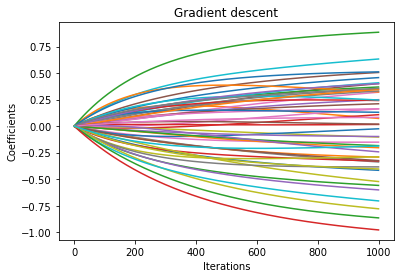

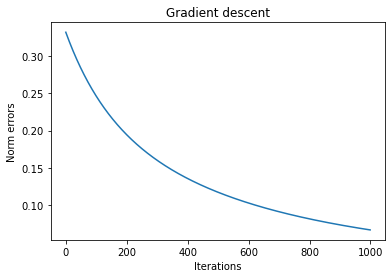

In [11]:
#GD
n, p = 100, 50
sigma0 = 2
mean0 = np.zeros(p)
cov0 = sigma0 * np.diag(np.ones(p))  # diagonal covariance
X, y, beta_true = gen_data(n, p, mean0, cov0, residualform='normal')
print(X.shape)
print(type(X))
print(y.shape)
sol = PathSolver(eta=1e-3, iter_max=1e3)
sol.OLS_GD(X, y)
coefs_gd = sol.coefs
errors_gd = estimation_error(coefs_gd, beta_true)
coefs_plot(coefs_gd, x_label="Iterations", title="Gradient descent")
coefs_plot(errors_gd, x_label="Iterations", y_label="Norm errors", title="Gradient descent")

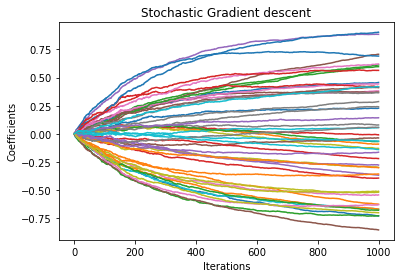

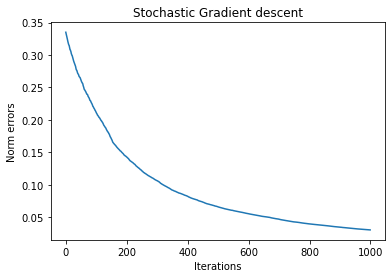

In [4]:
#batchSGD
n, p = 100, 50
sigma0 = 2
mean0 = np.zeros(p)
cov0 = sigma0 * np.diag(np.ones(p))  # diagonal covariance
X, y, beta_true = gen_data(n, p, mean0, cov0, residualform='normal')
sol = PathSolver(eta=1e-3, iter_max=1e3)
sol.OLS_batchSGD(X, y, m=10)
coefs_gd = sol.coefs
errors_gd = estimation_error(coefs_gd, beta_true)
coefs_plot(coefs_gd, x_label="Iterations", title="Stochastic Gradient descent")
coefs_plot(errors_gd, x_label="Iterations", y_label="Norm errors", title="Stochastic Gradient descent")

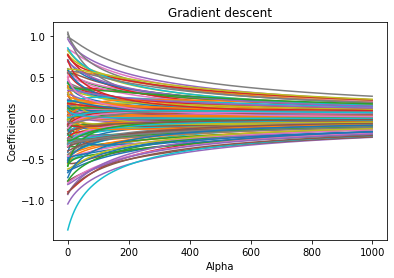

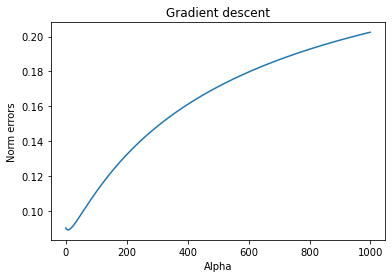

In [5]:
#ridge_path_sklearn
alphas = np.arange(0, 1000, 1)
n, p = 100, 150
sigma0 = 2
mean0 = np.zeros(p)
cov0 = sigma0 * np.diag(np.ones(p))  # diagonal covariance
X, y, beta_true = gen_data(n, p, mean0, cov0, residualform='normal')
sol = PathSolver(eta=1e-3, iter_max=1e7)
sol.ridge_path_sklearn(X, y, alphas)
coefs_gd = sol.coefs
errors_gd = estimation_error(coefs_gd, beta_true)
coefs_plot(coefs_gd, alphas, x_label="Alpha", title="Gradient descent")
coefs_plot(errors_gd, alphas, x_label="Alpha", y_label="Norm errors", title="Gradient descent")

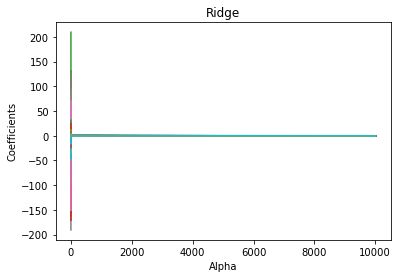

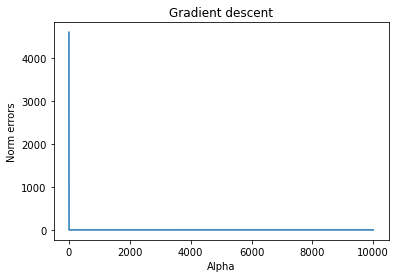

In [6]:
#ridge_path_inverse

alphas = np.arange(0, 10000, 1)
n, p = 100, 150
sigma0 = 2
mean0 = np.zeros(p)
cov0 = sigma0 * np.diag(np.ones(p))  # diagonal covariance
X, y, beta_true = gen_data(n, p, mean0, cov0, residualform='normal')
sol = PathSolver(eta=1e-3, iter_max=1e7)
sol.ridge_path_inverse(X, y, alphas)
coefs_gd = sol.coefs
errors_gd = estimation_error(coefs_gd, beta_true)
coefs_plot(coefs_gd, alphas, x_label="Alphas", title="Ridge")
coefs_plot(errors_gd, alphas, x_label="Alphas", y_label="Norm errors", title="Gradient descent")

In [12]:
z = np.zeros([123])
print(z.shape)
print(int('-1'))

(123,)
-1


(30956, 123)
(30956,)
[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


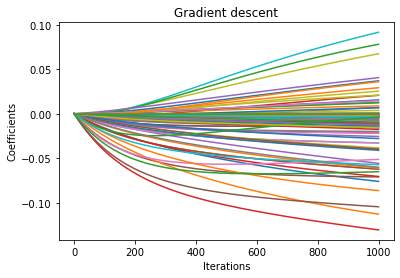

In [20]:
dataX = []
dataY = []
with open('a1a.t','r') as fp:
    lines = fp.readlines()
    for line in lines:
        splitline = line.split(' ')
        dataY.append(int(splitline[0]))
        tmp = np.zeros([123])
        for item in splitline[1:]:
            splititem = item.split(':')
            if len(splititem) > 1:
                tmp[int(splititem[0]) - 1] = int(splititem[1])
        dataX.append(tmp)

dataX = np.array(dataX)
dataY = np.array(dataY)
alphas = np.arange(0, 10000, 1)
sol = PathSolver(eta=1e-3, iter_max=1e3)
sol.OLS_GD(dataX, dataY)
coefs_gd = sol.coefs
coefs_plot(coefs_gd, x_label="Iterations", title="Gradient descent")